In [1]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import statistics
import networkx as nx

# 1) Download DF

In [2]:
#modifiche: cambiare data e togliere lang eng
m = SocialETL(query="(#eurovision OR #covid OR #pridemonth OR #grammys OR #justiceforjohnnydepp OR #putin OR #russia OR #ukraine OR #war)", pages=10, recent=False) #strangerthings4 

Output()

## creazione 1 df

In [3]:
user_id=m.df['author_id'] 
set_user=set(user_id)
#un utente può aver fatto più di un tweet, in questo modo andiamo a vedere i suoi ultimi tweet solo una volta.
print(len(set_user))

806


In [4]:
#estarre pure retweeted_user_id per edge
hashtag_for_user={}
tweet_for_user={}
retweet_for_user={}
conversation_for_user={}
verified_for_user={}
location_for_user={}

for e in set_user:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=2)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user[e]=u.df['conversation_id'].tolist()
    tweet_for_user[e]=u.df['id'].tolist() 
    location_for_user[e]=u.df['author.location'].tolist()
    verified_for_user[e]=u.df['author.verified']

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

caught requests exception: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /2/users/1495480590572961792/tweets?expansions=author_id%2Cin_reply_to_user_id%2Creferenced_tweets.id%2Creferenced_tweets.id.author_id%2Centities.mentions.username%2Cattachments.poll_ids%2Cattachments.media_keys%2Cgeo.place_id&tweet.fields=attachments%2Cauthor_id%2Ccontext_annotations%2Cconversation_id%2Ccreated_at%2Centities%2Cgeo%2Cid%2Cin_reply_to_user_id%2Clang%2Cpublic_metrics%2Ctext%2Cpossibly_sensitive%2Creferenced_tweets%2Creply_settings%2Csource%2Cwithheld&user.fields=created_at%2Cdescription%2Centities%2Cid%2Clocation%2Cname%2Cpinned_tweet_id%2Cprofile_image_url%2Cprotected%2Cpublic_metrics%2Curl%2Cusername%2Cverified%2Cwithheld&media.fields=alt_text%2Cduration_ms%2Cheight%2Cmedia_key%2Cpreview_image_url%2Ctype%2Curl%2Cwidth%2Cpublic_metrics&poll.fields=duration_minutes%2Cend_datetime%2Cid%2Coptions%2Cvoting_status&place.fields=contained_within%2Ccountry%2Ccountry_

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

caught requests exception: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [5]:
user_id=[]
tweet_id=[]
hashtag=[]
retweet=[]
location=[]
verified=[]
conversation=[]
for u,h in hashtag_for_user.items():
    user_id.append(u)
    hashtag.append(h)
for u,t in tweet_for_user.items():
    tweet_id.append(t)
for u,r in retweet_for_user.items():
    retweet.append(r)
for u,l in location_for_user.items():
    location.append(l)
for u,v in verified_for_user.items():
    verified.append(v)
for u,c in conversation_for_user.items():
    conversation.append(c)

In [6]:
loc=[]
for lists in location:
    nest_loc=[]
    for el in lists:  
        if isinstance(el,float):
            nest_loc.append(0) #remove nan locations
        elif isinstance(el,str):
            nest_loc.append(statistics.mode(lists)) #set as locaton the most used one
    loc.append(nest_loc)


In [7]:
#create a pandas dataframe
df_nodes=pd.DataFrame({"user_id":user_id,
                       'tweet_id':tweet_id,
                      'retweet_id': retweet,
                       'conversation_id':conversation,
                      "hashtag":hashtag,
                     'location':loc,
                     'verified':verified})
df_nodes

,user_id,tweet_id,retweet_id,conversation_id,hashtag,location,verified
0,1072480807699267584,"[1556751934635364353, 1556751774136033280, 155...","[1891490382, 16133530, 438381992, 129799947832...","[1556751934635364353, 1556751774136033280, 155...","[[us, ukraine], [standwithukraine], [greenhydr...","[0, 0, 0, 0, 0, 0, 0, 0]",2 False 3 False 11 False 13 Fals...
1,1517163777489133573,"[1556752266106896387, 1556722943463493632, 155...","[1517163777489133573, 1517163777489133573, 151...","[1556752266106896387, 1556722943463493632, 155...","[[mykolayiv, ukraine], [cossack], [kherson], [...","[Free World, Free World, Free World, Free Worl...",0 False 1 False 5 False 8 Fals...
2,66364750,"[1556752198322774016, 1556752146158198784, 155...","[1204804619555217408, 1158585210, 106687417, 2...","[1556752198322774016, 1556752146158198784, 155...","[[ukraine, armukrainenow, ukrainewar], [cumex,...","[Frankfurt, Germany, Frankfurt, Germany, Frank...",1 False 2 False 3 False 5 Fals...
3,2538270204,"[1556752290568077314, 1556751539158622208, 155...","[835552373615493120, 392930821, 1369701486, 13...","[1556752290568077314, 1556751539158622208, 155...","[[ukraine], [algeria, tunisia, gulf], [georgia...","[The Internets , The Internets , The Internets...",1 False 3 False 5 False 6 Fals...
4,1518718363207299074,[1556650992275378177],[1518718363207299074],[1556650992275378177],"[[woke, mcu, thor, shehulk, bargirlfail], [drk...",[0],"37 False Name: author.verified, dtype: bool"
...,...,...,...,...,...,...,...
801,1420711554270511107,"[1556758391413940224, 1556757352539455489, 155...","[384927198, 384927198, 384927198, 384927198, 3...","[1556758391413940224, 1556757352539455489, 155...","[[astensionismo, lacorsaalvoto, la7, italexit,...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",7 False 8 False 11 False 18 Fals...
802,29187013,[],[],[],"[[corriere, news, italy, world, cnn, notizie, ...",[],"Series([], Name: author.verified, dtype: bool)"
803,1461448568,"[1556753785824976900, 1556748560544272386, 155...","[1495480590572961792, 3104222776, 3104222776, ...","[1556753785824976900, 1556748560544272386, 155...","[[ukraine, donetsk], [ukrainewar], [ukrainewar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0 False 1 False 2 False 4 Fals...
804,40591485,"[1556760527426273281, 1556760154871418880, 155...","[3287964841, 1199156143, 1395180510968651777, ...","[1556760527426273281, 1556760154871418880, 155...","[[diagnostics, biotechnology, diagnostictestin...","[Everywhere, Everywhere, Everywhere, Everywher...",0 False 1 False 2 False 3 Fals...


## creazione 2 df (con id_user_retweet)

In [8]:
user_ret=set()
for u in df_nodes['retweet_id']:
    user_ret.update(u)
print(len(user_ret))

3255


In [19]:
#estarre pure retweeted_user_id per edge
hashtag_for_user_ret={}
tweet_for_user_ret={}
retweet_for_user_ret={}
conversation_for_user_ret={}
verified_for_user_ret={}
location_for_user_ret={}

for e in user_ret:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    #print(u.df['entities.hashtags'])
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] =u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user_ret[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user_ret[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user_ret[e]=u.df['conversation_id'].tolist()
    tweet_for_user_ret[e]=u.df['id'].tolist() 
    location_for_user_ret[e]=u.df['author.location'].tolist()
    verified_for_user_ret[e]=u.df['author.verified']
user_id_ret=[]
tweet_id_ret=[]
hashtag_ret=[]
retweet_ret=[]
location_ret=[]
verified_ret=[]
conversation_ret=[]
for u,h in hashtag_for_user_ret.items():
    user_id_ret.append(u)
    hashtag_ret.append(h)
for u,t in tweet_for_user_ret.items():
    tweet_id_ret.append(t)
for u,r in retweet_for_user_ret.items():
    retweet_ret.append(r)
for u,l in location_for_user_ret.items():
    location_ret.append(l)
for u,v in verified_for_user_ret.items():
    verified_ret.append(v)
for u,c in conversation_for_user_ret.items():
    conversation_ret.append(c)
loc=[]
for lists in location_ret:
    nest_loc=[]
    for el in lists:  
        if isinstance(el,float):
            nest_loc.append(0) #remove nan locations
        elif isinstance(el,str):
            nest_loc.append(statistics.mode(lists)) #set as locaton the most used one
    loc.append(nest_loc)
#create a pandas dataframe
df_nodes_ret=pd.DataFrame({"user_id":user_id_ret,
                       'tweet_id':tweet_id_ret,
                      'retweet_id': retweet_ret,
                       'conversation_id':conversation_ret,
                      "hashtag":hashtag_ret,
                     'location':loc,
                     'verified':verified})
df_nodes_ret

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

rate limit exceeded: sleeping 274.88207840919495 secs


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

rate limit exceeded: sleeping 295.02317667007446 secs
caught requests exception: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

rate limit exceeded: sleeping 293.4068193435669 secs
caught requests exception: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

rate limit exceeded: sleeping 305.19853353500366 secs
caught requests exception: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

UnboundLocalError: local variable 'df' referenced before assignment

## creazione df finale

In [20]:
df=pd.concat([df_nodes,df_nodes_ret])

NameError: name 'df_nodes_ret' is not defined

In [21]:
df

NameError: name 'df' is not defined

In [2]:
#df_nodes.to_csv('4438_users_csv')
df_nodes=pd.read_csv('4438_users_csv')
#codici per prova csv
df_nodes['hashtag']=df_nodes['hashtag'].apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].apply(eval)
#df_nodes['verified']=df_nodes['verified'].map(eval)
#df_nodes['location']=df_nodes['location'].apply(eval)

## preprocessing 

In [3]:
def user_set(u):
    user=set()
    user.add(u)
    return user
user=df_nodes['user_id'] #save for nodes
df_nodes['user_id']=df_nodes['user_id'].map(int)
df_nodes['user_id']=df_nodes['user_id'].map(user_set) #users into a set

In [4]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
#nested_list=[['onepiece', 'onepiecefilmred'], ['dbacks']]

In [6]:
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(to_sets)
#df_nodes['conversation_id']=df_nodes['conversation_id'].map(to_sets)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(to_sets)
df_nodes['verified']=df_nodes['verified'].map(to_sets)
df_nodes['location']=df_nodes['location'].map(to_sets)

In [7]:
df_nodes

,Unnamed: 0,user_id,tweet_id,retweet_id,hashtag,location,verified
0,0,{632276693},"{1556006364446695426, 1538613953445908480, 151...","{974881901600264192, 62053208, 1290441690, 295...","{nfldraft, nextlevelrams, onepiece1053, rallyt...","{a, n, [, , ,, ]}","{:, 4, 6, 0, h, 1, F, l, p, b, d, 9, \n, u, ,,..."
1,1,{2386380738},"{1550619686341328896, 1556005155421954048, 155...","{1504351932843929605, 859603229172051969, 1224...","{, dish, valentinoafterclub, 1, dish_, sabakan...","{\, だ, 0, I, [, 𓌉, 域, ', /, D, S, u, ,, H, し, ...","{:, 4, 6, 0, h, 1, F, l, g, p, b, d, 9, \n, u,..."
2,2,{731210404823740417},"{1552730376950452226, 1551949188925112320, 155...","{2595088842, 934810674450059265, 380648579, 60...","{chernobaevka, russianwarcrimes, zelenskyy, ar...","{a, n, [, , ,, ]}","{:, 4, 6, 0, h, 1, F, l, p, b, d, 9, \n, u, ,,..."
3,3,{314157950},"{1555956100863778819, 1555996446134091776, 155...","{21087719, 19140613, 950724820991447040, 15840...","{rechtsstaat, switzerland, impfung, wef, coron...","{a, n, [, , ,, ]}","{:, 4, 6, 0, h, 1, F, l, p, b, d, 9, \n, u, ,,..."
4,4,{27542573},"{1550496042877083648, 1556009107127242752, 155...","{1373371839062347785, 970318176570478594}","{gaza, russia, gazaunderattack, indiegame, rog...","{B, a, i, o, [, , r, S, u, ã, ,, ], z, l, ', P}","{:, 4, 0, h, 1, F, l, p, b, d, \n, u, ,, v, f,..."
...,...,...,...,...,...,...,...
4433,4433,{793071405965475841},"{1556004123358666753, 1555925128038457347, 155...","{605126134, 1295405245011460096, 520690173, 14...","{ptsd, breaking, goa, food, ukraine, farming, ...","{a, g, d, m, n, [, U, , K, E, o, ,, ], i, l, ...","{:, 4, 6, 0, h, 1, F, l, p, b, d, 9, \n, u, ,,..."
4434,4434,{2275138549},"{1554698803713908738, 1555584290825637891, 155...","{1174276237084069888, 934810674450059265, 3541...","{animallovers, themeowedclub, meowedofficial, ...","{a, n, [, r, U, , ], ,, c, i, '}","{:, 4, 6, 0, h, 1, F, l, p, b, d, 9, \n, u, ,,..."
4435,4435,{1157318905930457090},"{1555518506635890688, 1504835564163399681, 151...","{1438050186203320320, 198949082, 1494192096785...","{, bleach_anime, 13cp, pppppp, spy_family, ama...","{a, n, [, , ,, ]}","{:, 4, 6, 0, h, 1, F, l, p, b, d, 9, \n, u, ,,..."
4436,4436,{1471423949904957441},"{1556012326813401094, 1555951815434178561, 155...","{435006062, 3160691427, 1449033484824154118, 4...","{taiwan, ursuladegage, oqtf, morbihan, attal, ...","{a, n, [, , ,, ]}","{:, 4, 6, 0, h, 1, F, l, p, b, d, 9, \n, u, ,,..."


# 2) Categorizzazione utenti

In [10]:
with open('hashtags_300.json', 'r') as f:
    my_dict = json.load(f)

In [11]:
proukr=set()
prorus=set()
pax=set()
for k,v in my_dict.items():
    for e in v:
        if k=='proukr':
            proukr.update(e)
        elif k=='pax':
            pax.update(e)
        elif k=='prorus':
            prorus.update(e)

In [13]:
cat=set.union(proukr,prorus,pax)
count1=0
count4=0
index1=[]
index4=[]

for i, row in enumerate(df_nodes['hashtag']): 
    if row.intersection(cat)==set():#no intersezione   
        #print(row.intersectionn(cat))
        #print("l'utente {}  appartiene alla 4 categoria".format(row.intersection(cat)))
        #print("4 categoria", row)
        count4 += 1
        index4.append(i)
        
    else: #c'è intersezione: uno della 3 categorie
        #print("non è la 4 categoria perchè contiene",row.intersection(cat))
       # if row.intersection(proukr)!=set(): #c'è intersez con proukr
            count1 += 1
            index1.append(i) #aggiungo alle rige da tgliere
            print("l'utente {} non  appartiene alla 4 categoria perchè usa {}".format(df_nodes['user_id'].loc[i],row.intersection(cat)))

l'utente {2386380738} non  appartiene alla 4 categoria perchè usa {'nftgiveaway'}
l'utente {731210404823740417} non  appartiene alla 4 categoria perchè usa {'zelenskyy', 'russianwarcrimes', 'armukrainenow', 'mykolaiv', 'ukrainewar', 'ukrainerussianwar', 'nikopol', 'ukrainewillwin', 'russians', 'russiaisateroriststate', 'ukraine', 'odessa', 'russia', 'mariupol', 'lviv', 'donetsk', 'kharkiv', 'ukrainerussiawar', 'russian', 'ukrainianarmy', 'melitopol', 'kherson', 'ukrainian', 'himars', 'ukrainians', 'stoprussianow', 'russiaisaterrorisstate', 'luhansk', 'kyiv', 'ukraina'}
l'utente {314157950} non  appartiene alla 4 categoria perchè usa {'deutschland', 'switzerland', 'berlin', 'schroeder', 'selenskyj', 'putin', 'fdp'}
l'utente {27542573} non  appartiene alla 4 categoria perchè usa {'russia', 'ukraine'}
l'utente {1375905398503378945} non  appartiene alla 4 categoria perchè usa {'slavaukraini', 'genocide', 'russia', 'nato', 'ukraine'}
l'utente {1009511346} non  appartiene alla 4 categoria pe

l'utente {1463058961876209678} non  appartiene alla 4 categoria perchè usa {'russianukrainianwar', 'weareallukrainians', 'russianwarcrimes', 'ukrainewar', 'ukrainerussianwar', 'russiainvadedukraine', 'russiaisateroriststate', 'ukraine', 'ruzzia', 'russiaukrainewar', 'russia', 'ukrainerussiawar', 'russian', 'stopthewar', 'ukraineinvasion', 'ukrainerussia', 'amnesty', 'russiaisaterrorriststate', 'estonia', 'russiaterroriststate', 'russiaisaterrorisstate', 'standwithukraine'}
l'utente {830466647584563200} non  appartiene alla 4 categoria perchè usa {'afghanistan', 'kherson', 'russia', 'syria', 'biden', 'ukraine'}
l'utente {1422616604177797120} non  appartiene alla 4 categoria perchè usa {'amnesty', 'ukraine', 'russie'}
l'utente {932232350800506880} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1533605687741272065} non  appartiene alla 4 categoria perchè usa {'nfts'}
l'utente {720298583296061440} non  appartiene alla 4 categoria perchè usa {'russia', 'putin', 'gas', 'do

l'utente {1440078023160569858} non  appartiene alla 4 categoria perchè usa {'ukraine', 'covid19'}
l'utente {815799090063687680} non  appartiene alla 4 categoria perchè usa {'art'}
l'utente {916656611787198465} non  appartiene alla 4 categoria perchè usa {'russian', 'ukraine', 'torycostoflivingcrisis', 'generalelectionnow'}
l'utente {1517157673480957953} non  appartiene alla 4 categoria perchè usa {'fella', 'russiaterroriststate', 'nafofellas', 'putinwarcriminal', 'slavaukraini', 'genocideofukrainians', 'russiaisaterrorisstate', 'russiainvadedukraine', 'wearenafo', 'standwithukraine', 'russiaisaterroriststate', 'fellas', 'russiaisateroriststate', 'russian', 'ukraine', 'nafo'}
l'utente {1301891230280962048} non  appartiene alla 4 categoria perchè usa {'catsoftwitter', 'oscars', 'staysafe', 'cats', 'catlover', 'landscape', 'caturday'}
l'utente {1036763559915663360} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {75144761} non  appartiene alla 4 categoria perchè usa {'tai

l'utente {2752812483} non  appartiene alla 4 categoria perchè usa {'russianukrainianwar', 'russianwarcrimes', 'breaking', 'russianwarcrimesinukraine', 'putinhitler', 'osint', 'agnescallamardmustresign', 'ukraine', 'war', 'russia', 'russiaukrainewar', 'nazirussia', 'aerorozvidka', 'stoprussianow', 'standwithukraine', 'russiaisaterrorisstate', 'drone', 'luhansk', 'genocideofukrainians'}
l'utente {822928148773961729} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {956663425379155968} non  appartiene alla 4 categoria perchè usa {'fortnite', 'oscars'}
l'utente {889192338622480384} non  appartiene alla 4 categoria perchè usa {'twitter'}
l'utente {1270691588566593536} non  appartiene alla 4 categoria perchè usa {'taiwan', 'beautiful', 'nature', 'us', 'russia', 'photography', 'naturephotography', 'animals'}
l'utente {1496772443435847681} non  appartiene alla 4 categoria perchè usa {'ukraine', 'neverforget'}
l'utente {187796215} non  appartiene alla 4 categoria perchè usa {'ta

l'utente {18044209} non  appartiene alla 4 categoria perchè usa {'problem', 'zelensky', 'twitter', 'partisan', 'hate', 'russia', 'nuclear', 'russians', 'climateemergency', 'biden', 'iran', 'ukraine', 'love'}
l'utente {1488587564286156803} non  appartiene alla 4 categoria perchè usa {'nftart', 'pentest', 'nftartist', 'ukrainewillwin', 'pentesting', 'blood', 'nfts', 'russia', 'nowar', 'nftcommunity', 'russiaisaterroriststate', 'ukrainerussiawar', 'youtuber', 'metaverse', 'charity', 'eth', 'nftgiveaway', 'cybersecurity', 'spotify', 'ukraineunderattack', 'nft', 'btc', 'usa', 'love', 'cryptocurrency'}
l'utente {397452000} non  appartiene alla 4 categoria perchè usa {'russianukrainianwar', 'genocide', 'warinukraine', 'mykolaiv', 'ukrainewar', 'ukrainerussianwar', 'nuclear', 'help', 'russiainvadedukraine', 'russians', 'victory', 'terrorism', 'ukraine', 'war', 'schroeder', 'russia', 'europe', 'russiaisaterroriststate', 'russian', 'africa', 'toretsk', 'us', 'ukrainian', 'estonia', 'turkey', 'be

l'utente {14163474} non  appartiene alla 4 categoria perchè usa {'ukraine', 'guerreenukraine'}
l'utente {786655582224777216} non  appartiene alla 4 categoria perchè usa {'russia', 'ukraine'}
l'utente {1304539441566973959} non  appartiene alla 4 categoria perchè usa {'music'}
l'utente {921546184019333121} non  appartiene alla 4 categoria perchè usa {'russian', 'slavaukraini', 'mariupol', 'amnesty', 'azov', 'russiaisaterrorisstate', 'azovstaldefenders', 'breakingnews', 'ukrainian', 'azovstal', 'ukraine', 'war'}
l'utente {1458327834016034819} non  appartiene alla 4 categoria perchè usa {'taiwan', 'propaganda', 'mykolaiv', 'russians', 'agnescallamardmustresign', 'terrorism', 'ukraine', 'putinwarcriminal', 'russia', 'putin', 'russiaisaterroriststate', 'ucraina', 'nazirussia', 'slavaukraini', 'stoprussianow', 'standwithukraine', 'russiaisaterrorisstate', 'iran', 'nafo'}
l'utente {2393247008} non  appartiene alla 4 categoria perchè usa {'slavaukraini', 'armukrainenow', 'russia', 'mariodraghi'

l'utente {1466083563565158404} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'breaking', 'ukrainewillwin', 'vinnytsia', 'russians', 'ukraine', 'olenivka', 'putinwarcriminal', 'freeukraine', 'russia', 'mariupol', 'putin', 'donetsk', 'ukrainerussiawar', 'fckputin', 'russiaisaterroriststate', 'russian', 'zaporizhzhia', 'dnipro', 'azovstal', 'russiaterroriststate', 'standwithukraine', 'russiaisaterrorisstate', 'ukraineunderattack', 'germany', 'luhansk'}
l'utente {140600098} non  appartiene alla 4 categoria perchè usa {'twitter'}
l'utente {756251790} non  appartiene alla 4 categoria perchè usa {'olenivka', 'propaganda', 'amnestyinternational', 'breaking', 'armukrainenow', 'russia', 'ukrainewillwin', 'us', 'russiaisaterrorisstate', 'standwithukraine', 'uk', 'russian', 'crimea', 'ukraine', 'ukrainian', 'ukrainians'}
l'utente {3426333339} non  appartiene alla 4 categoria perchè usa {'adoptdontshop', 'standwithukraine', 'ukrainian', 'ukraine', 'caturday'}
l'utente {61894626} 

l'utente {2778616972} non  appartiene alla 4 categoria perchè usa {'quote', 'thursdayvibes', 'oscars', 'goddess', 'hollywoodstudios', 'research', 'children', 'army', 'boxing', 'hollywood'}
l'utente {633677514} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1071875087459123200} non  appartiene alla 4 categoria perchè usa {'france', 'onu'}
l'utente {277245931} non  appartiene alla 4 categoria perchè usa {'un', 'lgbtq', 'democrats', 'america', 'amnestyinternational', 'democracy', 'foxnews', 'bbcnews', 'ukrainerussianwar', 'lgbt', 'unitednations', 'ukraine', 'war', 'newyork', 'california', 'russia', 'russiaukrainewar', 'putin', 'europe', 'russiawarcrimes', 'uk', 'chicago', 'ohio', 'blm', 'france', 'bbc', 'twitter', 'us', 'finland', 'syria', 'georgia', 'belarus', 'texas', 'turkey', 'voteblue', 'eu', 'canada', 'germany', 'iran', 'poland', 'usa', 'google'}
l'utente {295084095} non  appartiene alla 4 categoria perchè usa {'taiwan', 'zelensky', 'russia', 'putin', 'ue', 'donet

l'utente {1419594139432374276} non  appartiene alla 4 categoria perchè usa {'belarus', 'blacklivesmatter', 'twitter', 'stoprussianaggression', 'world', 'russia', 'ukrainerussianwar', 'ukrainewillwin', 'europe', 'covid_19', 'ukraine', 'european'}
l'utente {2756171801} non  appartiene alla 4 categoria perchè usa {'russianukrainianwar', 'nazirussia', 'russianwarcrimes', 'armukrainenow', 'kherson', 'russia', 'ukrainewillwin', 'standwithukraine', 'russiaisaterroriststate', 'warcrimes', 'ukraine', 'war'}
l'utente {101720487} non  appartiene alla 4 categoria perchè usa {'belarus', 'russianwarcrimes', 'genocideofukrainians', 'stoprussianow', 'russie', 'armukrainenow', 'russia', 'poutine', 'stopputin', 'kharkiv', 'standwithukraine', 'syria', 'standwithukriane', 'russiaisateroriststate', 'russian', 'kyiv', 'ukraine'}
l'utente {88567354} non  appartiene alla 4 categoria perchè usa {'art'}
l'utente {497513916} non  appartiene alla 4 categoria perchè usa {'turkey', 'russian', 'cdnpoli', 'breaking',

l'utente {818429035378339840} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'russiaisateroriststate', '4308regiment', 'followukrainians', 'russiaisaterrorisstate', 'russians', 'russiaisaterroriststate', 'agnescallamardmustresign', 'genocideofukrainians', 'ukraine'}
l'utente {3321386251} non  appartiene alla 4 categoria perchè usa {'russia', 'amnesty', 'agnescallamardmustresign', 'ukraine', 'zaporizhzhia'}
l'utente {2730307379} non  appartiene alla 4 categoria perchè usa {'ukraine', 'eu'}
l'utente {1504101797652463617} non  appartiene alla 4 categoria perchè usa {'taiwan', 'america', 'breaking', 'democracy', 'covid_19', 'energy', 'hollywood', 'newyork', 'nfts', 'russia', 'europe', 'uk', 'motivation', 'france', 'metaverse', 'africa', 'india', 'syria', 'boxing', 'eth', 'japan', 'texas', 'afghanistan', 'turkey', 'italy', 'world', 'canada', 'germany', 'news', 'nft', 'poland', 'btc', 'usa', 'love'}
l'utente {1349171941089927172} non  appartiene alla 4 categoria perchè usa 

l'utente {14992557} non  appartiene alla 4 categoria perchè usa {'russiaterroriststate', 'olenivka', 'russia', 'putin', 'ukrainewillwin', 'standwithukraine', 'stoprussia', 'fckputin', 'olenivkamassacre', 'russiaisateroriststate', 'oprussia', 'ukraine'}
l'utente {1400518642261893120} non  appartiene alla 4 categoria perchè usa {'zelensky', 'ukraine'}
l'utente {1300102963344674818} non  appartiene alla 4 categoria perchè usa {'russia', 'putin', 'ukrainewillwin', 'finland', 'europe', 'ukraine'}
l'utente {800299436} non  appartiene alla 4 categoria perchè usa {'belarus', 'taiwan', 'russes', 'russie', 'poutine', 'amnesty', 'ukrainien', 'europe', 'ukraine', 'macron'}
l'utente {1493444647561019395} non  appartiene alla 4 categoria perchè usa {'cryptocurrency', 'nfts', 'nftcommunity', 'nft', 'btc', 'eth', 'metaverse'}
l'utente {805316860078080000} non  appartiene alla 4 categoria perchè usa {'putinwarcriminal', 'stoprussianow', 'breaking', 'mykolaiv', 'putinhitler', 'russia', 'ukrainewillwin',

l'utente {1298163067457503234} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {54873563} non  appartiene alla 4 categoria perchè usa {'bucha', 'russianukrainianwar', 'nature', 'breaking', 'ukrainewar', 'russiainvadedukraine', 'irpin', 'russians', 'warcrimes', 'ukraine', 'war', 'russiaukrainewar', 'russia', 'mariupol', 'roevswade', 'lviv', 'kharkiv', 'ukrainerussiawar', 'russiaisaterroriststate', 'russian', 'ukrainianarmy', 'vdv', 'melitopol', 'kherson', 'chernihiv', 'russiaisaterrorriststate', 'odesa', 'russiaterroriststate', 'kyiv', 'genocideofukrainians'}
l'utente {125467653} non  appartiene alla 4 categoria perchè usa {'cdnpoli', 'armukrainenow', 'amnestyinternational', 'russiainvadedukraine', 'agnescallamardmustresign', 'ukraine', 'olenivka', 'russia', 'ukrainewillresist', 'russiawarcrimes', 'uaarmy', 'russiaisaterroriststate', 'ukrainerussiawar', 'russian', 'zaporizhzhia', 'schroder', 'stopputin', 'ukrainian', 'amnesty', 'himars', 'stoprussianaggression', 'eu', '

l'utente {758353604575100928} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'biden', 'westandwithukraine', 'russianinvasion', 'ukraine', 'putinwarcriminal', 'freeukraine', 'russia', 'putin', 'nato', 'europa', 'russiaisaterroriststate', 'fckputin', 'ucraina', 'onu', 'russland', 'ucrania', 'ukrainerussiawar', 'russian', 'zelensky', 'cancelrussia', 'kherson', 'wagner', 'putinisawarcriminal', 'putinwarcrimes', 'syria', 'russianarmy', 'oprussia', 'turkey', 'moscow', 'italy', 'russiaterroriststate', 'ukraineunderattak', 'russie', 'russiaisaterrorisstate', 'ukraineunderattack', 'standwithukraine', 'anonymous', 'rusia', 'ukraina'}
l'utente {1292904575557668865} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'propaganda', 'orks', 'russianwarcrimesinukraine', 'ukrainewar', 'nuclear', 'slavaukraine', 'democracy', 'ukrainewillwin', 'russiainvadedukraine', 'victory', 'vinnytsia', 'russianfreedomlegion', 'frankfurt', 'ukraine', 'olenivka', 'russia', 'putin', 'don

l'utente {1497577711048474627} non  appartiene alla 4 categoria perchè usa {'lavrov', 'russianwarcrimes', 'democracy', 'ukrainewar', 'ukrainerussianwar', 'mig29', 'united24', 'izyum', 'stopputinnow', 'ukraine', 'russia', 'europe', 'bayraktar', 'uaarmy', 'freedom', 'russian', 'strongertogether', 'kherson', 'ukrainian', 'amnesty', 'european', 'eu', 'embraceukraine', 'standwithukraine', 'news', 'kyiv', 'armyofdrones'}
l'utente {12267642} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {38720385} non  appartiene alla 4 categoria perchè usa {'russia', 'mariupol', 'ukrainewar', 'ukrainewillwin', 'refugees', 'standwithukraine', 'nato', 'stoprussia', 'putinswar', 'russian', 'kharkiv', 'ukraine', 'estonia'}
l'utente {1499629072233680900} non  appartiene alla 4 categoria perchè usa {'btc', 'eth'}
l'utente {1400430213595545604} non  appartiene alla 4 categoria perchè usa {'nfts'}
l'utente {26054138} non  appartiene alla 4 categoria perchè usa {'olenivka', 'onev1', 'wearenafo', 'f

l'utente {914189168917573632} non  appartiene alla 4 categoria perchè usa {'taiwan', 'pzh2000', 'neverforget', 'ukraine', 'odessa', 'cherson', 'russiaukrainewar', 'nordstream1', 'nato', 'europa', 'russland', 'donezk', 'melitopol', 'habeck', 'himars', 'donbass', 'deutschland', 'graindeal', 'krieg', 'luhansk', 'iran', 'usa', 'krim'}
l'utente {1461077648722087946} non  appartiene alla 4 categoria perchè usa {'japan', 'taiwan', 'artist', 'btc', 'nfts', 'ukrainewar', 'eth', 'nft', 'ukrainerussiawar', 'usa', 'news', 'russian', 'art', 'ukraine', 'covid19'}
l'utente {106687417} non  appartiene alla 4 categoria perchè usa {'pzh2000', 'kherson', 'wagner', 'putin', 'agnescallamardmustresign', 'atacms', 'ukraine'}
l'utente {808729490} non  appartiene alla 4 categoria perchè usa {'afghanistan', 'lifestyle', 'nftart', 'eu', 'nature', 'russia', 'nft', 'iranian', 'iran', 'war'}
l'utente {285254192} non  appartiene alla 4 categoria perchè usa {'nazirussia', 'armukrainenow', 'russia', 'ukrainerussianwar

l'utente {694728027704406016} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {72871068} non  appartiene alla 4 categoria perchè usa {'taiwan', 'russia', 'ukraine', 'neverforget'}
l'utente {431865458} non  appartiene alla 4 categoria perchè usa {'nazirussia', 'us', 'russia', 'standwithukraine', 'russian', 'nafo', 'amnesty', 'ukraine'}
l'utente {1511794348836413451} non  appartiene alla 4 categoria perchè usa {'un', 'taiwan', 'russianukrainianwar', 'propaganda', 'amnestyinternational', 'moskau', 'ukrainerussianwar', 'ukrainewar', 'faschistischen', 'covid_19', 'kiew', 'biden', 'sanktionen', 'ol', 'ukraine', 'odessa', 'genozid', 'lettland', 'cherson', 'russia', 'mariupol', 'm777', 'putin', 'donetsk', 'nordstream1', 'nato', 'europa', 'ukrainerussiawar', 'russland', 'chinataiwan', 'russian', 'donezk', 'nazis', 'us', 'selenskyj', 'sbu', 'gas', 'euro', 'habeck', 'waffenlieferungen', 'russianarmy', 'ukrainian', 'himars', 'donbass', 'deutschland', 'eu', 'kriegsverbrechen', 'ber

l'utente {1547531292056731655} non  appartiene alla 4 categoria perchè usa {'bucha', 'taiwan', 'russianwarcrimes', 'mykolaiv', 'vinnytsia', 'russiainvadedukraine', 'russiaisateroriststate', 'ukraine', 'russia', 'mariupol', 'putin', 'kharkiv', 'ukrainerussiawar', 'freedom', 'azov', 'ukrainians', 'belarus', 'turkey', 'russiaterroriststate', 'donbas', 'russiaisaterrorisstate', 'standwithukraine', 'stoprussia', 'germany', 'genocideofukrainians'}
l'utente {1398472680} non  appartiene alla 4 categoria perchè usa {'oprussia', 'ukraine'}
l'utente {1162047161539923970} non  appartiene alla 4 categoria perchè usa {'grune', 'berlin', 'putin', 'fdp', 'ukrainekrieg', 'kiew', 'iran', 'kyiv', 'ukraine', 'frankfurt', 'krim'}
l'utente {860726142} non  appartiene alla 4 categoria perchè usa {'voteblue', 'demvoice1', 'onev1', 'demcast', 'wtpblue'}
l'utente {92731347} non  appartiene alla 4 categoria perchè usa {'russianukrainianwar', 'propaganda', 'breaking', 'armukrainenow', 'ukrainewar', 'ukrainerussia

l'utente {2974790014} non  appartiene alla 4 categoria perchè usa {'russianworld', 'ukrainian', 'russie', 'amnestyinternational', 'aviation', 'ukrainewar', 'standwithukraine', 'ukrainerussiawar', 'agnescallamardmustresign', 'shameonamnesty', 'ukrainianarmy', 'ukraine', 'zsu'}
l'utente {148449779} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {951581244113997831} non  appartiene alla 4 categoria perchè usa {'neverforget'}
l'utente {198553076} non  appartiene alla 4 categoria perchè usa {'russianukrainianwar', 'russianwarcrimes', 'slavaukraine', 'armukrainenow', 'ukrainewar', 'ukrainewillwin', 'neverforget', 'ukraine', 'war', 'russia', 'russiaukrainewar', 'ukrainerussiawar', 'russian', 'oekraine', 'ukrainian', 'rusia', 'amnesty', 'himars', 'orban', 'ukraineunderattack', 'cda', 'ukraina'}
l'utente {1274158454937128961} non  appartiene alla 4 categoria perchè usa {'cats'}
l'utente {1394184288279711744} non  appartiene alla 4 categoria perchè usa {'covid_19'}
l'utente {22

l'utente {380916739} non  appartiene alla 4 categoria perchè usa {'genocideofukrainians', 'stoprussianow', 'armukrainenow', 'russiaisaterrorisstate', 'animals', 'ukrainerussiawar', 'ukraine'}
l'utente {1236873278918135808} non  appartiene alla 4 categoria perchè usa {'ukraine', 'india'}
l'utente {1194878299} non  appartiene alla 4 categoria perchè usa {'habeck', 'deutschland', 'eu'}
l'utente {1731665011} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'slavaukraine', 'armukrainenow', 'ukrainewar', 'turpo', 'ukrainewillwin', 'russiaisateroriststate', 'agnescallamardmustresign', 'ukraine', 'war', 'genozid', 'russia', 'ukrainewillresist', 'ukrainerussiawar', 'russiaisaterroriststate', 'russian', 'zaporizhzhia', 'kherson', 'wearenafo', 'putinisawarcriminal', 'syria', 'amnesty', 'stoprussianow', 'sakpol', 'standwithukraine', 'ukraineunderattack', 'stpetersburg', 'genocideofukrainians'}
l'utente {1203428194529009664} non  appartiene alla 4 categoria perchè usa {'sketch'}
l'u

l'utente {1182645159978254342} non  appartiene alla 4 categoria perchè usa {'taiwan', 'zelensky', 'frexit', 'europe', 'covid_19', 'france'}
l'utente {1518303343550111747} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1479280113439150082} non  appartiene alla 4 categoria perchè usa {'un', 'himarstime', 'ukrainerussianwar', 'ukrainewar', 'ukrainewillwin', 'ukraine', 'russia', 'mariupol', 'europe', 'ukrainerussiawar', 'russiaisaterroriststate', 'cats', 'europeanunion', 'russian', 'ukrainianarmy', 'catsoftwitter', 'gas', 'wearenafo', 'ukrainian', 'amnesty', 'russiaisaterrorriststate', 'ukrainians', 'himars', 'russiaterroriststate', 'himarsoclock', 'russianlosses', 'followukrainians', 'russiaisaterrorisstate', 'usa', 'germany', 'art', 'kharkiv'}
l'utente {3917039188} non  appartiene alla 4 categoria perchè usa {'nftcollector', 'nftgiveaway', 'nftart', 'nfts', 'nftartist', 'nftcollections', 'ad', 'nftcommunity', 'animals', 'nftcommumity', 'nftproject', 'art', 'nft', 'btc'

l'utente {1550967679334240256} non  appartiene alla 4 categoria perchè usa {'army', 'india'}
l'utente {861738869045297153} non  appartiene alla 4 categoria perchè usa {'sweden', 'reality', 'eyes', 'cats', 'disgust', 'covid19'}
l'utente {1543554901640609792} non  appartiene alla 4 categoria perchè usa {'nftgiveaway', 'btc', 'nfts', 'nftcollections', 'nftcommunity', 'nft', 'nftproject', 'eth'}
l'utente {937999117} non  appartiene alla 4 categoria perchè usa {'rusia', 'russia', 'bakhmut', 'kherson', 'kharkiv', 'donetsk', 'nato', 'ukrainerussiawar', 'army', 'javelin', 'drones', 'ukraine'}
l'utente {1356969396200177666} non  appartiene alla 4 categoria perchè usa {'zdf', 'spd', 'merkel', 'habeck', 'sanktionen', 'scholz', 'covid19', 'fdp'}
l'utente {2351435732} non  appartiene alla 4 categoria perchè usa {'cdnpoli', 'olenivka', 'stopwar', 'russia', 'grain', 'stopputin', 'ukrainewillwin', 'amnesty', 'stoprussianwar', 'graindeal', 'standwithukraine', 'russiaisaterroriststate', 'crimea', 'ukrai

l'utente {1417744312004136962} non  appartiene alla 4 categoria perchè usa {'taiwan', 'breakingnews', 'breaking', 'russia', 'ukrainerussiawar', 'emergency', 'nancypelosi', 'russian', 'usa', 'ukraine'}
l'utente {15851279} non  appartiene alla 4 categoria perchè usa {'biden', 'crimesagainsthumanity', 'ukraine'}
l'utente {1230616881117245448} non  appartiene alla 4 categoria perchè usa {'russia', 'canada', 'germany', 'respect', 'ukraine'}
l'utente {1492601532340129792} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'breaking', 'russia', 'norway', 'russiaisaterrorisstate', 'standwithukraine', 'chernihiv', 'ukrainian', 'ukraine', 'caturday'}
l'utente {1349495859533250560} non  appartiene alla 4 categoria perchè usa {'urbanwarfare', 'taiwan', 'italy', 'mykolaiv', 'putin', 'stopputin', 'standwithukraine', 'nato', 'europa', 'ukrainerussiawar', 'russiaisaterroriststate', 'ucraina', 'ukraine'}
l'utente {1378995871015133184} non  appartiene alla 4 categoria perchè usa {'taiwan',

l'utente {1346088615336669187} non  appartiene alla 4 categoria perchè usa {'warinukraine', 'breaking', 'ukrainewar', 'ukrainerussianwar', 'sevastopol', 'agnescallamardmustresign', 'energy', 'ukraine', 'russia', 'russiaukrainewar', 'putin', 'europe', 'ukrainerussiawar', 'russiaisaterroriststate', 'russian', 'crimea', 'ukrainianarmy', 'zelensky', 'kherson', 'zaporizhzhya', 'ukrainian', 'ukrainians', 'stoprussianaggression', 'slavaukraini', 'standwithukraine', 'ukraineunderattack', 'stoprussia', 'kharkiv'}
l'utente {109831308} non  appartiene alla 4 categoria perchè usa {'ukraine', 'eu'}
l'utente {4871934887} non  appartiene alla 4 categoria perchè usa {'paris', 'un', 'russianwarcrimes', 'armukrainenow', 'ukrainewillwin', 'neverforget', 'ukraine', 'russia', 'europe', 'russian', 'ukrainianarmy', 'us', 'kherson', 'wearenafo', 'georgia', 'ukrainian', 'himars', 'russiaterroriststate', 'slavaukraini', 'russie', 'eu', 'stpetersburg', 'standwithukraine', 'actforukraine', 'stoprussia', 'azerbaij

l'utente {45998359} non  appartiene alla 4 categoria perchè usa {'taiwan', 'breaking', 'mykolaiv', 'novayakakhovka', 'russians', 'osint', 'russiansgohome', 'ukraine', 'russiaukrainewar', 'russia', 'donetsk', 'russiaisaterroriststate', 'ukrainerussiawar', 'russian', 'zaporizhzhia', 'kherson', 'bakhmut', 'india', 'moscow', 'stoprussianaggression', 'standwithukraine', 'stoprussia', 'luhansk', 'iran', 'kharkiv'}
l'utente {1334212703389413376} non  appartiene alla 4 categoria perchè usa {'russia', 'rusia'}
l'utente {1830107652} non  appartiene alla 4 categoria perchè usa {'covid_19', 'roevswade', 'covid19'}
l'utente {3863108655} non  appartiene alla 4 categoria perchè usa {'taiwan', 'france', 'onu'}
l'utente {4150044789} non  appartiene alla 4 categoria perchè usa {'lgbtq', 'himarstime', 'catsontwitter', 'ukrainerussianwar', 'ukrainewar', 'ukrainewillwin', 'onev1', 'veteransdeservebetter', 'resistanceunited', 'riseup', 'ukraine', 'war', 'zsu', 'staystrong', 'nowar', 'sea', 'ukrainerussiawar

l'utente {1037408429395136512} non  appartiene alla 4 categoria perchè usa {'terrorstateputin', 'pzh2000', 'russianwarcrimes', 'slavaukraini', 'berlin', 'russie', 'armukrainenow', 'amnesty', 'standwithukraine', 'himars', 'misstrauensvotum', 'russiaisaterroriststate', 'putinwarcrimes', 'russland', 'scholz', 'ukraine'}
l'utente {1096536221805961216} non  appartiene alla 4 categoria perchè usa {'taiwan', 'twitter', 'voteblue', 'russianwarcrimes', 'slavaukraini', 'newyork', 'slavaukraine', 'ukrainewar', 'voteblue2022', 'ukrainerussianwar', 'ukrainerussiawar', 'nazism', 'demcast', 'fresh', 'ukraine', 'wtpblue', 'democrats'}
l'utente {496910185} non  appartiene alla 4 categoria perchè usa {'covid19', 'wearamask', 'ukraine', 'olenivka'}
l'utente {706898545} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1524407649915265024} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {45788514} non  appartiene alla 4 categoria perchè usa {'armukrainenow', 'ukrainianarmy

l'utente {2967609148} non  appartiene alla 4 categoria perchè usa {'taiwan', 'peace', 'democracy', 'ukrainerussianwar', 'nuclear', 'ukrainewar', 'biden', 'energy', 'ukraine', 'war', 'elezioni2022', 'russia', 'putin', 'nato', 'europe', 'suomi', 'ukrainerussiawar', 'ucraina', 'freedom', 'eurovision', 'russian', 'europeanunion', 'ukrainianarmy', 'ukraina', 'zaporizhzhia', 'sweden', 'zelensky', 'twitter', 'ai', 'draghi', 'gas', 'finland', 'venaja', 'ukrainian', 'afghanistan', 'italy', 'eu', 'italia', 'germany', 'erdogan', 'scholz', 'usa'}
l'utente {243394220} non  appartiene alla 4 categoria perchè usa {'moscow', 'nazirussia', 'russianwarcrimes', 'olenivka', 'georgia', 'russiaterroriststate', 'russianwarcrimesinukraine', 'russia', 'crimesagainsthumanity', 'iran', 'standwithukraine', 'medvedev', 'respect', 'ukrainian', 'ukraine'}
l'utente {1519064467832807427} non  appartiene alla 4 categoria perchè usa {'taiwan', 'zelensky', 'twitter', 'iphone', 'amnestyinternational', 'standwithukraine', 

l'utente {1138317152920973312} non  appartiene alla 4 categoria perchè usa {'russia', 'european', 'switzerland', 'italia'}
l'utente {569886152} non  appartiene alla 4 categoria perchè usa {'belarus', 'un', 'amnestyinternational', 'russia', 'amnesty', 'standwithukraine', 'poland', 'nazirussia', 'ukraine'}
l'utente {411377266} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'ukraine', 'russia', 'mriyareport', 'ukrainerussiawar', 'russian', 'strongertogether', 'bakhmut', 'kherson', 'wearenafo', 'fellas', 'oprussia', 'ukrainian', 'slavaukraini', 'cybersecurity', 'infosec', 'standwithukraine', 'russiaisaterrorisstate', 'anonymous', 'kyiv', 'nafo'}
l'utente {242511482} non  appartiene alla 4 categoria perchè usa {'climatecrisis', 'japan', 'war', 'climateemergency'}
l'utente {2155915072} non  appartiene alla 4 categoria perchè usa {'russianworld', 'russia', 'standwithukraine', 'russian', 'ukraine'}
l'utente {940381354847502337} non  appartiene alla 4 categoria perchè usa {'lg

l'utente {1339666951350587392} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {922470541956612100} non  appartiene alla 4 categoria perchè usa {'covid_19', 'ukraine', 'covid19'}
l'utente {1128107333664395264} non  appartiene alla 4 categoria perchè usa {'midjourney'}
l'utente {26223770} non  appartiene alla 4 categoria perchè usa {'russia', 'russiaukrainewar', 'donbas', 'india', 'zelenskywarcriminal', 'kiev', 'ucraina'}
l'utente {1243829067180322822} non  appartiene alla 4 categoria perchè usa {'weareallukrainians', 'russianwarcrimes', 'stopthewar', 'democracy', 'freeukraine', 'standwithukraine', 'russiaisaterroriststate', 'kharkiv', 'ukraine'}
l'utente {357445002} non  appartiene alla 4 categoria perchè usa {'russiaukrainewar', 'putin', 'ukraine', 'ukrainerussiawar'}
l'utente {351867002} non  appartiene alla 4 categoria perchè usa {'drawing', 'art'}
l'utente {1209513152188239873} non  appartiene alla 4 categoria perchè usa {'btc', 'eth'}
l'utente {1335441330391011330

l'utente {969712190} non  appartiene alla 4 categoria perchè usa {'taiwan', 'armukrainenow', 'russianwarcrimesinukraine', 'ukrainerussianwar', 'ukrainewillwin', 'foodfighters', 'westandwithukraine', 'ukraine', 'slavaukrainii', 'russia', 'russiaisaterroriststate', 'russian', 'ukrainianarmy', 'kherson', 'wearenafo', 'georgia', 'nazirussia', 'standwithukraine', 'russiaisaterrorisstate'}
l'utente {1421478260878237701} non  appartiene alla 4 categoria perchè usa {'eurovision'}
l'utente {1541526412946989056} non  appartiene alla 4 categoria perchè usa {'nfts'}
l'utente {267068008} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {857677870860251138} non  appartiene alla 4 categoria perchè usa {'selenskyj', 'putin', 'krieg', 'habeck', 'krim', 'waffenlieferungen', 'sanktionen', 'ukraine', 'ukrainekrieg'}
l'utente {1385935776450551812} non  appartiene alla 4 categoria perchè usa {'spd', 'ukrainewillwin', 'standwithukraine', 'kyiv', 'ukraine'}
l'utente {1111053502376226835} non  

l'utente {835953318769868800} non  appartiene alla 4 categoria perchè usa {'russiaterroriststate', 'stoprussianow', 'armukrainenow', 'kyiv', 'helpukraine', 'russiaisaterrorisstate', 'standwithukraine', 'armukraine', 'russiaisaterroriststate', 'russiaisateroriststate', 'poland', 'art', 'ukraine', 'artwork'}
l'utente {52418395} non  appartiene alla 4 categoria perchè usa {'japan', 'taiwan', 'cbdoil', 'italy', 'us', 'russia', 'foxnews', 'donbas', 'nato', 'ukrainerussiawar', 'syria', 'rusia', 'amnesty', 'ukraine'}
l'utente {2504880438} non  appartiene alla 4 categoria perchè usa {'bundeskanzler', 'putin', 'scholz', 'ucraina', 'poland', 'ukraine', 'war'}
l'utente {441257228} non  appartiene alla 4 categoria perchè usa {'russia'}
l'utente {1372893984427769860} non  appartiene alla 4 categoria perchè usa {'zdf', 'ard', 'selenskyj', 'berlin'}
l'utente {315557943} non  appartiene alla 4 categoria perchè usa {'breaking', 'ad'}
l'utente {1336660338289340416} non  appartiene alla 4 categoria perch

l'utente {1217885951395057670} non  appartiene alla 4 categoria perchè usa {'sweden', 'turkey', 'italy', 'spotify', 'australia', 'moldova', 'lithuania', 'azerbaijan', 'latvia', 'germany', 'eurovision', 'poland', 'ukraine', 'ucraine', 'estonia'}
l'utente {450880548} non  appartiene alla 4 categoria perchè usa {'taiwan', 'breaking', 'ukraine'}
l'utente {1138849948349411329} non  appartiene alla 4 categoria perchè usa {'putin', 'tahlkoridoru'}
l'utente {23486177} non  appartiene alla 4 categoria perchè usa {'costoflivingcrisis', 'ukraine'}
l'utente {1426810488483102720} non  appartiene alla 4 categoria perchè usa {'news', 'radio', 'italia', 'climateemergency'}
l'utente {1327350167578808320} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {173845965} non  appartiene alla 4 categoria perchè usa {'art'}
l'utente {1485680860598706181} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1532970680081608704} non  appartiene alla 4 categoria perchè usa {'nftgiveawa

l'utente {1501642667696046080} non  appartiene alla 4 categoria perchè usa {'taiwan', 'russianwarcrimes', 'armukrainenow', 'russianwarcrimesinukraine', 'amnestyinternational', 'ukrainewillwin', 'russiainvadedukraine', 'russians', 'agnescallamardmustresign', 'terrorism', 'anonymous', 'ukraine', 'fightforukraine', 'putinwarcriminal', 'olenivka', 'russiaukrainewar', 'russia', 'putin', 'mariupol', 'europe', 'ukrainewillresist', 'russiaisaterroriststate', 'russian', 'terrorists', 'zaporizhzhia', 'warcrimesofrussia', 'kherson', 'azov', 'putinwarcrimes', 'terrorussia', 'russianarmy', 'olenivkamassacre', 'atacms', 'azovstal', 'nazirussia', 'russiaisaterrorriststate', 'oprussia', 'russiaterroriststate', 'slavaukraini', 'stoprussianow', 'followukrainians', 'helpukraine', 'russiaisaterrorisstate', 'ukraineunderattack', 'atacmsforukraine', 'luhansk', 'kyiv', 'kharkiv'}
l'utente {3182423444} non  appartiene alla 4 categoria perchè usa {'news'}
l'utente {44623108} non  appartiene alla 4 categoria pe

l'utente {1327744944086257666} non  appartiene alla 4 categoria perchè usa {'cdnpoli', 'hate', 'russia', 'syria', 'iran', 'ukraine'}
l'utente {337669103} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {752708580} non  appartiene alla 4 categoria perchè usa {'armukrainenow', 'kherson', 'standwithukraine', 'iran', 'ukrainianarmy', 'ukraine'}
l'utente {1373772003191099392} non  appartiene alla 4 categoria perchè usa {'breaking', 'russia', 'ukrainewillwin', 'ukraineunderattack', 'russiaisaterroriststate', 'ukrainerussiawar', 'agnescallamardmustresign', 'amnesty', 'ukraine'}
l'utente {1373703080701792256} non  appartiene alla 4 categoria perchè usa {'nft', 'btc', 'eth'}
l'utente {1416667645299118081} non  appartiene alla 4 categoria perchè usa {'paris', 'russie', 'poutine', 'donetsk', 'donbass', 'france', 'ukraine', 'macron'}
l'utente {2901889857} non  appartiene alla 4 categoria perchè usa {'ukrainearmy', 'ukrainerussiawar', 'ukraine', 'ukrainewillwin'}
l'utente {14261522

l'utente {1278630237887172608} non  appartiene alla 4 categoria perchè usa {'bucha', 'russianworld', 'taiwan', 'russianwarcrimes', 'peace', 'amnestyinternational', 'ukrainewar', 'ukrainewillwin', 'irpin', 'donestk', 'ukraine', 'donieck', 'war', 'olenivka', 'russia', 'russiaukrainewar', 'putin', 'donetsk', 'russiaisaterroriststate', 'ukrainerussiawar', 'russianaggression', 'ucraina', 'ucrania', 'russian', 'stopwar', 'zaporizhzhia', 'donezk', 'kherson', 'azov', 'ukrainian', 'azovstal', 'donbass', 'japan', 'donbas', 'kyiv', 'ukraina', 'stopwarinukraine'}
l'utente {3123631415} non  appartiene alla 4 categoria perchè usa {'joebiden', 'roevswade', 'nancypelosi', 'usa', 'ukraine'}
l'utente {1300175973846052867} non  appartiene alla 4 categoria perchè usa {'america', 'putin', 'erdogan', 'iran', 'rusia'}
l'utente {1444377869812121610} non  appartiene alla 4 categoria perchè usa {'follow'}
l'utente {3360460217} non  appartiene alla 4 categoria perchè usa {'russia', 'ukraine'}
l'utente {227267930

l'utente {1538209257593753601} non  appartiene alla 4 categoria perchè usa {'un', 'lavrov', 'amnestyinternational', 'ukrainewar', 'nuclear', 'russians', 'specialmilitaryoperation', 'ukraine', 'russia', 'putin', 'europe', 'uk', 'russian', 'france', 'sweden', 'zelensky', 'africa', 'kherson', 'india', 'finland', 'moldova', 'syria', 'newprofilepic', 'russianarmy', 'ukrainian', 'himars', 'nazi', 'donbass', 'ukrainians', 'turkey', 'japan', 'italy', 'estonia', 'eu', 'canada', 'latvia', 'germany', 'iran', 'poland', 'usa'}
l'utente {1453001977424711690} non  appartiene alla 4 categoria perchè usa {'america', 'putin', 'roevswade', 'usa'}
l'utente {2834010100} non  appartiene alla 4 categoria perchè usa {'nftart', 'cryptocurrency', 'nftartist', 'cybersec', 'hollywood', 'newyork', 'nfts', 'california', 'russia', 'photography', 'europe', 'uk', 'metaverse', 'redcarpet', 'covid19', 'nftcollector', 'hackers', 'gas', 'ai', 'india', 'eth', 'nftgiveaway', 'cybersecurity', 'video', 'nft', 'btc', 'usa', 'd

l'utente {3661684775} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'generalelectionnow', 'ukrainewar', 'turpo', 'kyiv', 'agnescallamardmustresign', 'russiaisateroriststate', 'ukraine', 'war', 'putinwarcriminal', 'freeukraine', 'russia', 'mariupol', 'costoflivingcrisis', 'russiaisaterroriststate', 'ukrainerussiawar', 'fellas', 'oprussia', 'estonia', 'torycostoflivingcrisis', 'slavaukraini', 'sakpol', 'russiaisaterrorisstate', 'standwithukraine', 'canada', 'ukraineunderattack', 'germany', 'anonymous', 'enoughisenough', 'genocideofukrainians'}
l'utente {1324315079878320128} non  appartiene alla 4 categoria perchè usa {'buffalo', 'blacklivesmatter', 'istandwithukraine', 'texas', 'democracy', 'demvoice1', 'russia', 'voteblue2022', 'roethevote', 'onev1', 'humanrights', 'ohio', 'blm', 'bidenharris', 'ukraine', 'wtpblue'}
l'utente {458841339} non  appartiene alla 4 categoria perchè usa {'syria', 'ukraine'}
l'utente {1275667762346708993} non  appartiene alla 4 categoria perc

l'utente {1518625050978570241} non  appartiene alla 4 categoria perchè usa {'russian', 'ukraine', 'ukrainians'}
l'utente {4464437113} non  appartiene alla 4 categoria perchè usa {'summer'}
l'utente {704247409} non  appartiene alla 4 categoria perchè usa {'ad'}
l'utente {994603074764328962} non  appartiene alla 4 categoria perchè usa {'france', 'onu'}
l'utente {1518745652116795393} non  appartiene alla 4 categoria perchè usa {'freedom', 'ukraine', 'democrats'}
l'utente {2751536594} non  appartiene alla 4 categoria perchè usa {'sweden', 'germany', 'eu', 'russia', 'nato', 'finland', 'uk', 'biden', 'ukraine'}
l'utente {592743922} non  appartiene alla 4 categoria perchè usa {'russes', 'ukraine', 'ue'}
l'utente {1497719063035928576} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'stoprussianow', 'ukrainerussianwar', 'standwithukraine', 'russiaisaterrorisstate', 'russians', 'uk', 'russiaisateroriststate', 'russian', 'ukrainian', 'azovstal', 'ukraine'}
l'utente {9898731376250

l'utente {258723792} non  appartiene alla 4 categoria perchè usa {'italy', 'energy', 'ukrainerussia', 'ukraine', 'love'}
l'utente {1543564077020086275} non  appartiene alla 4 categoria perchè usa {'nft', 'btc', 'eth'}
l'utente {1054729737254379521} non  appartiene alla 4 categoria perchè usa {'russia', 'amnesty', 'ukraine', 'putinwarcriminal'}
l'utente {1048110957476630528} non  appartiene alla 4 categoria perchè usa {'donezk', 'russia', 'russland', 'luhansk', 'ukraine', 'donbass'}
l'utente {1507714234506956803} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {2478306637} non  appartiene alla 4 categoria perchè usa {'summer'}
l'utente {1533806007712882688} non  appartiene alla 4 categoria perchè usa {'taiwan', 'russiaterroriststate', 'putinwarcriminal', 'russia', 'putin', 'ukrainewillwin', 'backboris', 'standwithukraine', 'nancypelosi', 'ukraine', 'bbc'}
l'utente {1547825502303375360} non  appartiene alla 4 categoria perchè usa {'freeukraine', 'ukraina', 'newprofilepic

l'utente {990357176798662656} non  appartiene alla 4 categoria perchè usa {'lgbtq', 'russianwarcrimes', 'russiaisateroriststate', 'ukraine', 'putinwarcriminal', 'freeukraine', 'russia', 'putin', 'nato', 'migranti', 'russiaisaterroriststate', 'ukrainerussiawar', 'ucraina', 'stopwar', 'zelensky', 'wagner', 'salvini', 'stoprussianaggression', 'russiaisaterrorisstate', 'standwithukraine', 'usa'}
l'utente {1518152686683799552} non  appartiene alla 4 categoria perchè usa {'russia', 'russian'}
l'utente {2312810112} non  appartiene alla 4 categoria perchè usa {'urbanwarfare', 'un', 'genocide', 'warinukraine', 'amnestyinternational', 'ukrainewillwin', 'stopputinnow', 'ukraine', 'russia', 'putin', 'russian', 'zaporizhzhia', 'finland', 'fellas', 'ukrainian', 'amnesty', 'japan', 'russiaterroriststate', 'standwithukraine', 'canada'}
l'utente {965384533376995329} non  appartiene alla 4 categoria perchè usa {'belarus', 'amnestyinternational', 'armukrainenow', 'standwithukraine', 'russian', 'ukraine'}

l'utente {191805388} non  appartiene alla 4 categoria perchè usa {'taiwan', 'zelensky', 'amnestyinternational', 'ukrainewar', 'covid19'}
l'utente {1556003785461350400} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {946895603983880192} non  appartiene alla 4 categoria perchè usa {'quotes', 'twitter', 'cyberwar', 'cybersecurity', 'infosec', 'hackers', 'cyberattack', 'news', 'ukraine', 'war'}
l'utente {1547973543224217601} non  appartiene alla 4 categoria perchè usa {'ukrainewar', 'btc', 'ukraine'}
l'utente {151698919} non  appartiene alla 4 categoria perchè usa {'sweden', 'vdv', 'russianukrainianwar', 'slavaukraini', 'us', 'amnestyinternational', 'russia', 'kherson', 'ukrainewillwin', 'standwithukraine', 'wearenafo', 'nato', 'finland', 'fellas', 'azovbattalion', 'ukraine', 'nafo'}
l'utente {163013423} non  appartiene alla 4 categoria perchè usa {'artist', 'draw', 'sketch', 'artistontwitter', 'art', 'ukraine'}
l'utente {806396805302849537} non  appartiene alla 4 categor

l'utente {1345732423238234112} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {2945051848} non  appartiene alla 4 categoria perchè usa {'summer'}
l'utente {1304116580284997632} non  appartiene alla 4 categoria perchè usa {'breaking', 'russia', 'armukrainenow', 'world', 'ukrainewillwin', 'russianlosses', 'standwithukraine', 'russians', 'stoprussia', 'european', 'standwithukriane', 'russian', 'amnesty', 'ukraine'}
l'utente {105578904} non  appartiene alla 4 categoria perchè usa {'covidisnotover', 'twitter', 'covid19'}
l'utente {152735590} non  appartiene alla 4 categoria perchè usa {'zelensky', 'russie', 'amnestyinternational', 'kiev', 'amnesty', 'ukraine'}
l'utente {1166456875732361217} non  appartiene alla 4 categoria perchè usa {'peace', 'thursdayvibes', 'russiaukrainewar', 'ukrainerussiawar', 'humanrights', 'warcrimes', 'ukraine', 'war'}
l'utente {913467051225812993} non  appartiene alla 4 categoria perchè usa {'europe', 'ukraine', 'russie'}
l'utente {15251860327733

l'utente {578415837} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'warinukraine', 'armukrainenow', 'putinhitler', 'ukrainewar', 'vinnytsia', 'ukrainerussianwar', 'russiaisateroriststate', 'ukraine', 'russia', 'russiaukrainewar', 'mariupol', 'bayraktar', 'russiaisaterroriststate', 'ukrainerussiawar', 'russianaggression', 'standwithukriane', 'russian', 'zaporizhzhia', 'azovstal', 'nazirussia', 'belarus', 'odesa', 'ukraineunderattak', 'standwithukraine', 'russiaisaterrorisstate', 'ukraineunderattack', 'kyiv', 'kharkiv'}
l'utente {1443842943215939611} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {36507708} non  appartiene alla 4 categoria perchè usa {'cdnpoli'}
l'utente {1534451072584097792} non  appartiene alla 4 categoria perchè usa {'un', 'russianwarcrimes', 'armukrainenow', 'mykolaiv', 'amnestyinternational', 'ukrainewillwin', 'russians', 'russiainvadedukraine', 'russiaisateroriststate', 'ukraine', 'europe', 'russiaisaterroriststate', 'ukrainerus

l'utente {1229863724007161856} non  appartiene alla 4 categoria perchè usa {'closetheskyoverukraine', 'nazirussia', 'putinwarcriminal', 'russia', 'ukrainewar', 'putinhitler', 'russiaukrainewar', 'glorytoukraine', 'standwithukraine', 'ukraineunderattack', 'putinisawarcriminal', 'stopputinnow', 'standwithukriane', 'georgia', 'ukraine'}
l'utente {1278059217778348032} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'genocide', 'russia', 'lilliputin', 'russiaisaterroriststate', 'fckputin', 'czarlilliputin'}
l'utente {1418195167090253827} non  appartiene alla 4 categoria perchè usa {'nfts'}
l'utente {1485357239921782786} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1123625587} non  appartiene alla 4 categoria perchè usa {'germany', 'eurovision', 'eurovision2023', 'embraceukraine'}
l'utente {1286683006497890304} non  appartiene alla 4 categoria perchè usa {'newprofilepic'}
l'utente {1498844496947073024} non  appartiene alla 4 categoria perchè usa {'amnest

l'utente {1079004152729096192} non  appartiene alla 4 categoria perchè usa {'un', 'russianwarcrimes', 'armukrainenow', 'amnestyinternational', 'ukraine', 'freeazovstaldefenders', 'olenivka', 'russiaisaterroriststate', 'saveazov', 'saveazovstaldefenders', 'savemariupoldefenders', 'olenivkamassacre', 'atacms', 'turkey', 'russiaterroriststate', 'stoprussianow', 'followukrainians', 'russiaisaterrorisstate', 'standwithukraine', 'genocideofukrainians'}
l'utente {1487003563498868736} non  appartiene alla 4 categoria perchè usa {'taiwan', 'america', 'australia', 'breakingnews', 'war'}
l'utente {1528050265080926208} non  appartiene alla 4 categoria perchè usa {'nfts'}
l'utente {933064087218606081} non  appartiene alla 4 categoria perchè usa {'russiaterroriststate', 'russianwarcrimes', 'amnestyinternational', 'russiaisaterrorisstate', 'stoprussia', 'russiaisateroriststate', 'russian', 'ukraine'}
l'utente {2655098660} non  appartiene alla 4 categoria perchè usa {'btc'}
l'utente {15054854412309381

l'utente {1498181956093292546} non  appartiene alla 4 categoria perchè usa {'bucha', 'russianwarcrimes', 'stopputinswar', 'america', 'amnestyinternational', 'armukrainenow', 'ukrainewar', 'taiwanisnotchina', 'ukrainewillwin', 'russianwarcrimesinukraine', 'putinhitler', 'irpin', 'stopputinnow', 'sevastopol', 'azovstaldefenders', 'biden', 'agnescallamardmustresign', 'ukraine', 'war', 'olenivka', 'artillery', 'russia', 'russiaukrainewar', 'mariupol', 'lviv', 'putin', 'nato', 'europa', 'russiawarcrimes', 'uaarmy', 'russiaisaterroriststate', 'ukrainerussiawar', 'russianaggression', 'ukrainewillresist', 'fckputin', 'russian', 'crimea', 'ukrainianarmy', 'zaporizhzhia', 'istandwithukraine', 'kherson', 'stopputin', 'terrorussia', 'patron', 'ukrainian', 'amnesty', 'himars', 'ukrainians', 'belarus', 'turkey', 'odesa', 'russiaterroriststate', 'stoprussianow', 'standwithukraine', 'ukraineunderattack', 'russiaisaterrorisstate', 'stoprussia', 'erdogan', 'georgianlegion', 'fckptn'}
l'utente {138184459

l'utente {234935320} non  appartiene alla 4 categoria perchè usa {'nature', 'naturephotography', 'usa', 'guerreenukraine', 'germany', 'ukraine'}
l'utente {407093504} non  appartiene alla 4 categoria perchè usa {'kherson', 'russia', 'donbas', 'draghi', 'ucraina'}
l'utente {2466925058} non  appartiene alla 4 categoria perchè usa {'taiwan', 'afghanistan', 'russian', 'breaking', 'india', 'sevastopol', 'ukrainerussiawar', 'covid19', 'terrorism', 'crimea', 'ukraine', 'zaporizhzhia'}
l'utente {745707823} non  appartiene alla 4 categoria perchè usa {'paris', 'ukraine', 'covid19'}
l'utente {2978990578} non  appartiene alla 4 categoria perchè usa {'taiwan', 'twitter', 'zelensky', 'canada', 'covid19'}
l'utente {835226775915474944} non  appartiene alla 4 categoria perchè usa {'nato', 'biden', 'switzerland', 'ukraine'}
l'utente {706137994235879424} non  appartiene alla 4 categoria perchè usa {'russianworld', 'un', 'taiwan', 'genocide', 'amnestyinternational', 'russians', 'mh17', 'ukraine', 'olenivk

l'utente {279426237} non  appartiene alla 4 categoria perchè usa {'oekraine', 'russia', 'zelenskywarcriminal', 'co', 'ukraine', 'covid19'}
l'utente {1151139523604156416} non  appartiene alla 4 categoria perchè usa {'afghanistan', 'ukraine', 'hollywood', 'democrats'}
l'utente {2477246450} non  appartiene alla 4 categoria perchè usa {'zelenskywarcriminal', 'ukraine'}
l'utente {762442051} non  appartiene alla 4 categoria perchè usa {'twitter', 'putin', 'ucrania', 'erdogan', 'rusia', 'invasion', 'covid19'}
l'utente {1417040739981316097} non  appartiene alla 4 categoria perchè usa {'zelensky', 'frexit', 'amnestyinternational', 'ukrainewar', 'macron'}
l'utente {706157451041570818} non  appartiene alla 4 categoria perchè usa {'summer'}
l'utente {53232669} non  appartiene alla 4 categoria perchè usa {'ukrainerussiawar', 'ukraine'}
l'utente {1117571358689460226} non  appartiene alla 4 categoria perchè usa {'draw'}
l'utente {127482427} non  appartiene alla 4 categoria perchè usa {'peace', 'dkpol

l'utente {1214814378891067392} non  appartiene alla 4 categoria perchè usa {'bucha', 'un', 'genocide', 'refugees', 'buchamassacre', 'stoprussianagression', 'warcrimes', 'westandwithukraine', 'ukraine', 'wearenato', 'russia', 'mariupol', 'europe', 'humanrights', 'osce', 'russian', 'crimea', 'strongertogether', 'standupforukraine', 'melitopol', 'moldova', 'standingwithukraine', 'georgia', 'glorytoukraine', 'japan', 'odesa', 'eu', 'stoprussianaggression', 'unsc', 'donbas', 'standwithukraine', 'stoprussia', 'kyiv', 'kharkiv'}
l'utente {1498018609007931392} non  appartiene alla 4 categoria perchè usa {'taiwan', 'russianukrainianwar', 'ukrainewar', 'ukrainerussianwar', 'ukrainewillwin', 'foodfighters', 'russiainvadedukraine', 'ukraine', 'olenivka', 'russia', 'russiaukrainewar', 'ukrainerussiawar', 'russiaisaterroriststate', 'russian', 'us', 'lithuania', 'zaporizhzhya', 'ukrainian', 'eu', 'russiaisaterrorisstate', 'latvia', 'kharkiv'}
l'utente {1351249548010782726} non  appartiene alla 4 cate

l'utente {1375906402993111051} non  appartiene alla 4 categoria perchè usa {'berlin', 'russianwarcrimesinukraine', 'mariupol', 'kharkiv', 'russiaisaterrorisstate', 'russiaisaterroriststate', 'ukraine', 'fdp'}
l'utente {1550467118340128768} non  appartiene alla 4 categoria perchè usa {'ad'}
l'utente {576518138} non  appartiene alla 4 categoria perchè usa {'russia', 'ukraine'}
l'utente {822491406107312129} non  appartiene alla 4 categoria perchè usa {'peace', 'hands', 'contemporaryart', 'warcriminals', 'ukraine', 'war', 'timewilltell', 'blood', 'hate', 'russia', 'sea', 'putin', 'fckputin', 'eurovision', 'hitler', 'redcarpet', 'sweden', 'zelensky', 'water', 'stopputin', 'warcriminal', 'art', 'watch', 'italy', 'slavaukraini', 'clouds', 'stpetersburg', 'russiaisaterrorisstate', 'standwithukraine', 'oilpaintings', 'kajstenvall', 'oilpainting', 'president', 'ukraina', 'love'}
l'utente {1443939431061274630} non  appartiene alla 4 categoria perchè usa {'google'}
l'utente {976483362167803906} no

l'utente {3255219208} non  appartiene alla 4 categoria perchè usa {'nftcollector', 'nftgiveaway', 'art', 'nftart', 'nfts', 'nftartist', 'nftcollections', 'ad', 'nftcommunity', 'animals', 'nftcommumity', 'nftproject', 'nftcollectors', 'nft', 'btc', 'eth', 'love', 'metaverse'}
l'utente {1416087555511042048} non  appartiene alla 4 categoria perchè usa {'zelensky', 'russie', 'ukrainiens', 'ukraine', 'ue', 'sbu', 'donetsk', 'azov', 'marioupol', 'canada', 'ukrainerussiawar', 'usa', 'nazi', 'guerreenukraine', 'france', 'covid19', 'donbass'}
l'utente {3939134007} non  appartiene alla 4 categoria perchè usa {'ukrainerussia', 'poland', 'ukraine', 'refugees'}
l'utente {1455605844092104705} non  appartiene alla 4 categoria perchè usa {'putin'}
l'utente {384489749} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {3385525762} non  appartiene alla 4 categoria perchè usa {'ukraine', 'neverforget'}
l'utente {1145367791257751552} non  appartiene alla 4 categoria perchè usa {'mykolaiv', 

l'utente {254234234} non  appartiene alla 4 categoria perchè usa {'nftcollector', 'nftart', 'nfts', 'foxnews', 'nftcommunity', 'nftproject', 'nftcollectors', 'nft', 'btc', 'eth', 'cryptocurrency'}
l'utente {1079124846} non  appartiene alla 4 categoria perchè usa {'tiktok', 'taiwan', 'ukrainian', 'ukraine'}
l'utente {2731642700} non  appartiene alla 4 categoria perchè usa {'summer'}
l'utente {1020133859864850434} non  appartiene alla 4 categoria perchè usa {'quotes', 'eurovision', 'quote'}
l'utente {134538595} non  appartiene alla 4 categoria perchè usa {'eurovision'}
l'utente {1511855373271117827} non  appartiene alla 4 categoria perchè usa {'drawing'}
l'utente {1513770790579318784} non  appartiene alla 4 categoria perchè usa {'pzh2000', 'amnestyinternational', 'ukraine', 'russia', 'russiawarcrimes', 'ukrainerussiawar', 'russian', 'schroder', 'finland', 'fellas', 'patron', 'belarus', 'helsinki', 'kriegsverbrechen', 'spd', 'standwithukraine', 'misstrauensvotum', 'scholz', 'nafo'}
l'uten

l'utente {707601442052263936} non  appartiene alla 4 categoria perchè usa {'japan', 'art'}
l'utente {1520297261967851526} non  appartiene alla 4 categoria perchè usa {'btc', 'eth'}
l'utente {3591543072} non  appartiene alla 4 categoria perchè usa {'turkey', 'taiwan', 'russian', 'eu', 'breaking', 'russia', 'amnesty', 'nato', 'azerbaijan', 'warcrimes', 'drones', 'ukraine', 'bbc'}
l'utente {1509883801094270981} non  appartiene alla 4 categoria perchè usa {'india'}
l'utente {756069343478161408} non  appartiene alla 4 categoria perchè usa {'russia', 'putin', 'russianarmy'}
l'utente {1541360297398906880} non  appartiene alla 4 categoria perchè usa {'nftgiveaway', 'nfts', 'nftcommunity', 'nft', 'btc', 'eth'}
l'utente {161492541} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1200721367584432128} non  appartiene alla 4 categoria perchè usa {'nftgiveaway', 'russia', 'help', 'biden', 'btc', 'eth'}
l'utente {1478405549234561031} non  appartiene alla 4 categoria perchè usa {'rus

l'utente {2597168593} non  appartiene alla 4 categoria perchè usa {'russianworld', 'russie', 'propaganda', 'ukraine', 'kherson', 'russia', 'mykolaiv', 'dnipro', 'standwithukraine', 'stoprussia', 'agnescallamardmustresign', 'amnesty', 'nafo'}
l'utente {1506371745976094734} non  appartiene alla 4 categoria perchè usa {'demcast', 'demvoice1', 'onev1', 'resistanceunited', 'oprussia', 'ukraine'}
l'utente {1936864711} non  appartiene alla 4 categoria perchè usa {'taiwan'}
l'utente {1082202821775085569} non  appartiene alla 4 categoria perchè usa {'twitter'}
l'utente {3432873417} non  appartiene alla 4 categoria perchè usa {'svpol', 'ukrainewillwin', 'ukraine', 'standwithukraine'}
l'utente {2194564833} non  appartiene alla 4 categoria perchè usa {'paris', 'canada', 'covid19'}
l'utente {815817911034122241} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1542886321101864962} non  appartiene alla 4 categoria perchè usa {'taiwan', 'genocide', 'biden', 'warcrimes', 'azovbattalion

l'utente {78677507} non  appartiene alla 4 categoria perchè usa {'breaking'}
l'utente {131232437} non  appartiene alla 4 categoria perchè usa {'taiwan', 'us', 'russia', 'poutine', 'covid_19', 'macron'}
l'utente {1374967305386520579} non  appartiene alla 4 categoria perchè usa {'news', 'russia', 'covid19'}
l'utente {1386965321173643270} non  appartiene alla 4 categoria perchè usa {'un', 'russianukrainianwar', 'russianwarcrimes', 'genocide', 'amnestyinternational', 'mykolaiv', 'russians', 'agnescallamardmustresign', 'russiaisateroriststate', 'ukraine', 'olenivka', 'mariupol', 'europe', 'russiaisaterroriststate', 'france', 'kherson', 'ukrainian', 'azovstal', 'russiaisaterrorriststate', 'russiaterroriststate', 'slavaukraini', 'followukrainians', 'russiaisaterrorisstate', 'standwithukraine', 'germany', 'poland', 'usa'}
l'utente {1318555327642697730} non  appartiene alla 4 categoria perchè usa {'russia', 'putin', 'syria'}
l'utente {142663237} non  appartiene alla 4 categoria perchè usa {'you

l'utente {1399115626686431236} non  appartiene alla 4 categoria perchè usa {'taiwan', 'ukrainewar', 'ukrainewillwin', 'covid_19', 'kiew', 'avdiivka', 'sanktionen', 'biden', 'terrorism', 'frankfurt', 'ukraine', 'russia', 'russiaukrainewar', 'putin', 'europa', 'ukrainerussiawar', 'nancypelosi', 'russland', 'russian', 'donezk', 'zelensky', 'euro', 'himars', 'donbass', 'ford', 'deutschland', 'kriegsverbrechen', 'usa', 'krim'}
l'utente {1522944003683069952} non  appartiene alla 4 categoria perchè usa {'bucha', 'russianukrainianwar', 'russianwarcrimes', 'armukrainenow', 'amnestyinternational', 'mykolaiv', 'agnescallamardmustresign', 'warcrimes', 'ukraine', 'war', 'olenivka', 'russia', 'lviv', 'russiaisaterroriststate', 'wearenafo', 'fellas', 'amnesty', 'odesa', 'russiaterroriststate', 'crimesagainsthumanity', 'kharkiv', 'nafo'}
l'utente {2884964301} non  appartiene alla 4 categoria perchè usa {'gh'}
l'utente {778851722793852928} non  appartiene alla 4 categoria perchè usa {'beautiful', 'cats

l'utente {1506768457240563717} non  appartiene alla 4 categoria perchè usa {'un', 'amnestyinternational', 'ukrainewar', 'warcrimes', 'ukraine', 'russia', 'mariupol', 'donetsk', 'nato', 'europe', 'uk', 'ukrainerussiawar', 'europeanunion', 'russian', 'ukrainianarmy', 'france', 'macron', 'zelensky', 'azov', 'ukrainian', 'ukrainerussia', 'eu', 'donbas', 'germany', 'scholz', 'usa'}
l'utente {432704122} non  appartiene alla 4 categoria perchè usa {'tiktok', 'california', 'catsoftwitter', 'roevswade'}
l'utente {1429115178235408385} non  appartiene alla 4 categoria perchè usa {'himarstime', 'russianukrainianwar', 'amnestyinternational', 'armukrainenow', 'moskau', 'ukrainewar', 'ukrainewillwin', 'skadovsk', 'russiainvadedukraine', 'armukraine', 'azovstaldefenders', 'sanktionen', 'donestk', 'ukraine', 'olenivka', 'putinwarcriminal', 'russia', 'donetsk', 'ukrainewillresist', 'russiaisaterroriststate', 'ukrainerussiawar', 'russland', 'ukrainianarmy', 'zaporizhzhia', 'kherson', 'putinisawarcriminal

l'utente {814562064815521796} non  appartiene alla 4 categoria perchè usa {'urbanwarfare', 'taiwan', 'breaking', 'amnestyinternational', 'russia', 'ukraina', 'syria', 'russian', 'energy', 'ukraine'}
l'utente {1493517003209986057} non  appartiene alla 4 categoria perchè usa {'russes', 'russianwarcrimes', 'stoprussianaggression', 'amnestyinternational', 'amnesty', 'russiaisaterrorisstate', 'russiaisaterroriststate', 'agnescallamardmustresign', 'russian', 'ukraine'}
l'utente {95963751} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {942953654738288640} non  appartiene alla 4 categoria perchè usa {'reality', 'texas', 'lgbtq', 'twitter', 'poetry', 'blog', 'hope', 'thursdayvibes', 'mustread', 'animals', 'poems', 'music', 'promotion', 'terrorists', 'art', 'love', 'artwork'}
l'utente {1465422672939171841} non  appartiene alla 4 categoria perchè usa {'grune', 'covid_19', 'biden', 'ard', 'ukraine', 'russia', 'zdf', 'putin', 'grunen', 'macron', 'selenskyj', 'draghi', 'merkel', '

l'utente {1498686397200445445} non  appartiene alla 4 categoria perchè usa {'paris', 'lavrov', 'breaking', 'ukrainerussianwar', 'biden', 'ukraine', 'russia', 'russiaukrainewar', 'putin', 'mariupol', 'donetsk', 'nato', 'borisjohnson', 'ukrainerussiawar', 'russian', 'france', 'zaporizhzhia', 'zelensky', 'melitopol', 'us', 'kherson', 'ukrainian', 'amnesty', 'nazi', 'donbass', 'italy', 'eu', 'germany', 'poland'}
l'utente {1542455352096346112} non  appartiene alla 4 categoria perchè usa {'twitter'}
l'utente {2885401024} non  appartiene alla 4 categoria perchè usa {'nature', 'ukraine'}
l'utente {872563003} non  appartiene alla 4 categoria perchè usa {'eurovision', 'eurovision2023'}
l'utente {1341462944} non  appartiene alla 4 categoria perchè usa {'sweden', 'photography', 'art', 'caturday'}
l'utente {165376366} non  appartiene alla 4 categoria perchè usa {'america', 'news', 'lithuania', 'uk', 'azerbaijan', 'latvia', 'usa', 'eurovision', 'eurovision2023', 'ukraine', 'bbc', 'estonia'}
l'utente

l'utente {1069371520210923522} non  appartiene alla 4 categoria perchè usa {'turkey', 'artillery', 'russia', 'kyiv', 'ucrania', 'rusia', 'ukraine'}
l'utente {160237355} non  appartiene alla 4 categoria perchè usa {'russianukrainianwar', 'amnesty', 'france', 'ukraine'}
l'utente {1045439233283035139} non  appartiene alla 4 categoria perchè usa {'midjourney'}
l'utente {1497856170589138948} non  appartiene alla 4 categoria perchè usa {'paris', 'taiwan', 'propaganda', 'armukrainenow', 'mykolaiv', 'ukrainewar', 'amnestyinternational', 'vinnytsia', 'ukrainewillwin', 'putinhitler', 'breaking', 'stopputinnow', 'agnescallamardmustresign', 'ukraine', 'stoprussianterror', 'olenivka', 'nafofellas', 'artillery', 'russia', 'mariupol', 'putin', 'ukrainerussiawar', 'france', 'zaporizhzhia', 'macron', 'kremlin', 'schroder', 'putler', 'kherson', 'bakhmut', 'wearenafo', 'fellas', 'olenivkamassacre', 'ukraineinvasion', 'ukrainerussia', 'standforukraine', 'nazirussia', 'amnesty', 'khersonisukraine', 'gloryt

l'utente {1386744000783261705} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'ukrainewillwin', 'agnescallamardmustresign', 'unitednations', 'ukraine', 'olenivka', 'freeukraine', 'russia', 'europe', 'russiaisaterroriststate', 'fckputin', 'itarmyofukraine', 'russian', 'standupforukraine', 'warcrimesofrussia', 'kherson', 'stopputin', 'vinnytsya', 'teamonefist', 'oprussia', 'russiaisaterrorriststate', 'orban', 'russiaterroriststate', 'eu', 'stoprussianow', 'standwithukraine', 'russiaisaterrorisstate', 'stoprussia', 'anonymous', 'kyiv'}
l'utente {17897932} non  appartiene alla 4 categoria perchè usa {'dogsoftwitter', 'adoptdontshop'}
l'utente {457940190} non  appartiene alla 4 categoria perchè usa {'zelensky', 'taiwan', 'russia', 'fenerbahce', 'btc'}
l'utente {224430095} non  appartiene alla 4 categoria perchè usa {'taiwan', 'un', 'lavrov', 'grain', 'nuclear', 'northkorea', 'biden', 'ukraine', 'russia', 'putin', 'russian', 'covid19', 'twitter', 'africa', 'us', 'syria', 'u

l'utente {1328564717712007174} non  appartiene alla 4 categoria perchè usa {'ukraine', 'india'}
l'utente {1301627563064913923} non  appartiene alla 4 categoria perchè usa {'taiwan', 'zelensky', 'norway', 'chinataiwan', 'ukraine', 'metaverse'}
l'utente {1459573511433953287} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1257337475044913158} non  appartiene alla 4 categoria perchè usa {'newyork'}
l'utente {1469399861003005952} non  appartiene alla 4 categoria perchè usa {'sketch'}
l'utente {579873395} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1134870219233513472} non  appartiene alla 4 categoria perchè usa {'nftcollector', 'nftgiveaway', 'art', 'nftart', 'nfts', 'nftartist', 'nftcollections', 'ad', 'nftcommunity', 'animals', 'nftcommumity', 'nftproject', 'nftcollectors', 'nft', 'btc', 'eth', 'love', 'metaverse'}
l'utente {1223688330136772609} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {3676639098} non  appartiene alla 4 cat

l'utente {246177668} non  appartiene alla 4 categoria perchè usa {'slavaukraini', 'breaking', 'russia', 'ukraine', 'agnescallamardmustresign', 'russian', 'amnesty', 'zaporizhzhia'}
l'utente {1526215941322858496} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1882760150} non  appartiene alla 4 categoria perchè usa {'taiwan', 'slavaukraine', 'breaking', 'ukrainewar', 'skadovsk', 'ukrainewillwin', 'russiainvadedukraine', 'avdiivka', 'ukraine', 'war', 'olenivka', 'russia', 'russiaukrainewar', 'mariupol', 'nato', 'ukrainerussiawar', 'russiaisaterroriststate', 'chinataiwan', 'russian', 'melitopol', 'kherson', 'ukrainian', 'nazirussia', 'standwithukraine', 'iran'}
l'utente {2359407182} non  appartiene alla 4 categoria perchè usa {'vogue', 'ukraine', 'zelenskywarcriminal'}
l'utente {75794724} non  appartiene alla 4 categoria perchè usa {'wecanandmust', 'standwithukraine', 'iranian', '1988massacre', 'westand4freeiran', 'iran', 'westandwithukraine', 'ukraine'}
l'utente {149510

l'utente {1548952739773927424} non  appartiene alla 4 categoria perchè usa {'artist', 'nftart', 'nftartist', 'cryptoartist', 'naturephotography', 'nftjapan', 'contemporaryart', 'painting', 'nfts', 'photography', 'nftcommunity', 'nftcollectors', 'nftproject', 'metaverse', 'artwork', 'nftcollector', 'nftcollections', 'eth', 'nftgiveaway', 'cryptoart', 'nftartwork', 'nftcommumity', 'nft', 'art'}
l'utente {1547109012751060992} non  appartiene alla 4 categoria perchè usa {'italy', 'usa', 'germany', 'europeanunion', 'unitednations', 'france', 'ukraine'}
l'utente {1526909315205963779} non  appartiene alla 4 categoria perchè usa {'bucha', 'russianwarcrimes', 'genocide', 'armukrainenow', 'russianwarcrimesinukraine', 'amnestyinternational', 'russians', 'osint', 'ukraine', 'olenivka', 'russiaukrainewar', 'russiaisaterroriststate', 'ukrainerussiawar', 'ukrainian', 'himars', 'khersonisukraine', 'stoprussianow', 'standwithukraine', 'stoprussia', 'genocideofukrainians'}
l'utente {4838839234} non  app

l'utente {4705285344} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1206954154863874053} non  appartiene alla 4 categoria perchè usa {'un', 'taiwan', 'ukrainewar', 'ukriane', 'ukraine', 'odessa', 'war', 'russia', 'putin', 'europe', 'zelensky', 'donezk', 'azov', 'azovstal', 'azerbaijan', 'zelenskywarcriminal', 'nazism', 'russen', 'usa'}
l'utente {310990008} non  appartiene alla 4 categoria perchè usa {'bucha', 'odesa', 'russian', 'mariupol', 'lviv', 'kharkiv', 'irpin', 'ukrainerussiawar', 'wtpblue', 'chernihiv', 'warcrimes', 'kyiv', 'azovstal', 'ukraine', 'war'}
l'utente {1524471789715349504} non  appartiene alla 4 categoria perchè usa {'nfts'}
l'utente {1472922369526218759} non  appartiene alla 4 categoria perchè usa {'zelensky', 'russie', 'ukraine', 'amnesty', 'lgbt', 'europe', 'france', 'covid19', 'macron'}
l'utente {910250230293069825} non  appartiene alla 4 categoria perchè usa {'zelensky', 'ukrainerussiawar', 'ukraine'}
l'utente {4820923273} non  appartiene all

l'utente {3306459479} non  appartiene alla 4 categoria perchè usa {'breaking', 'mykolaiv', 'vinnytsia', 'kiew', 'ukraine', 'odessa', 'cherson', 'russia', 'nato', 'europa', 'fsb', 'bakhmut', 'selenskyj', 'ukrainian', 'donbass', 'odesa', 'donbas', 'wagenknecht', 'usa'}
l'utente {166287523} non  appartiene alla 4 categoria perchè usa {'taiwan', 'quote', 'russia', 'putin', 'putinswar', 'putinwarcrimes', 'ukrainerussiawar', 'radio', 'diy', 'music', 'ukraine', 'covid19'}
l'utente {890257781386870784} non  appartiene alla 4 categoria perchè usa {'taiwan', 'usa', 'nancypelosi', 'ukraine', 'covid19', 'macron'}
l'utente {1076749520} non  appartiene alla 4 categoria perchè usa {'olenivka', 'amnestyinternational', 'mykolaiv', 'breaking', 'putin', 'ukrainewillwin', 'amnesty', 'kharkiv', 'putinisawarcriminal', 'ucraina', 'agnescallamardmustresign', 'ukrainian', 'russianinvasion', 'ukraine'}
l'utente {20229363} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1471932352851062791} non

l'utente {2669447159} non  appartiene alla 4 categoria perchè usa {'california', 'ukraine', 'adoptdontshop', 'newyork'}
l'utente {1501648021481742336} non  appartiene alla 4 categoria perchè usa {'taiwan', 'zelensky', 'us', 'democracy', 'draghi', 'humanrights', 'russian', 'ukrainian', 'ukraine', 'nazi'}
l'utente {1221857229827203072} non  appartiene alla 4 categoria perchè usa {'caturday'}
l'utente {1457003759926534148} non  appartiene alla 4 categoria perchè usa {'tiktok', 'ukraine'}
l'utente {3215961051} non  appartiene alla 4 categoria perchè usa {'taiwan', 'propaganda', 'ukraine', 'odessa', 'fckptn', 'olenivka', 'mariupol', 'putin', 'nato', 'selenskyi', 'blm', 'russland', 'hitler', 'nazis', 'neveragain', 'amnesty', 'nazi', 'donbass', 'krieg', 'minsk', 'russen', 'scholz', 'usa', 'krim'}
l'utente {327024457} non  appartiene alla 4 categoria perchè usa {'covid_19', 'covid19'}
l'utente {50993130} non  appartiene alla 4 categoria perchè usa {'texas', 'africa', 'russie', 'amnestyinternat

l'utente {609993108} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1235147870732537856} non  appartiene alla 4 categoria perchè usa {'taiwan', 'crowdfunding', 'ue', 'adoptdontshop', 'radio', 'usa', 'ukraine'}
l'utente {4085047485} non  appartiene alla 4 categoria perchè usa {'taiwan', 'peace', 'america', 'russia', 'nowar', 'naturephotography', 'europe', 'ukrainerussiawar', 'ukrainian', 'ukraine', 'love'}
l'utente {452575517} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'warinukraine', 'russia', 'mariupol', 'standwithukraine', 'russiaisaterroriststate', 'russian', 'ukraine'}
l'utente {1462419238430334976} non  appartiene alla 4 categoria perchè usa {'taiwan', 'frexit', 'ukraine', 'covid19', 'macron'}
l'utente {609095542} non  appartiene alla 4 categoria perchè usa {'turkey', 'olenivka', 'slavaukraini', 'armukrainenow', 'russia', 'gas', 'donetsk', 'standwithukraine', 'canada', 'ukrainian', 'ukraine'}
l'utente {948844069} non  appartiene alla 4 cate

l'utente {1503720652636921860} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'armukrainenow', 'mykolaiv', 'ukrainewar', 'amnestyinternational', 'ukrainewillwin', 'russians', 'russiaisateroriststate', 'agnescallamardmustresign', 'ukraine', 'war', 'olenivka', 'nafofellas', 'russia', 'ukrainerussiawar', 'russiaisaterroriststate', 'france', 'kherson', 'stopputin', 'ukrainian', 'himars', 'slavaukraini', 'stoprussianow', 'standwithukraine', 'ukraineunderattack', 'kharkiv', 'nafo'}
l'utente {21264417} non  appartiene alla 4 categoria perchè usa {'ohio', 'russia', 'olenivka'}
l'utente {879944958320402432} non  appartiene alla 4 categoria perchè usa {'nftcollector', 'nftgiveaway', 'art', 'nftart', 'nfts', 'nftartist', 'nftcollections', 'ad', 'nftcommunity', 'animals', 'nftcommumity', 'nftproject', 'nftcollectors', 'nft', 'btc', 'eth', 'love', 'metaverse'}
l'utente {1225852097624756224} non  appartiene alla 4 categoria perchè usa {'drawing'}
l'utente {1126148950019514374} non 

l'utente {55308257} non  appartiene alla 4 categoria perchè usa {'russianwarcrimes', 'slavaukraini', 'covidisnotover', 'standwithukraine', 'ukrainian', 'ukraine', 'covid19'}
l'utente {31875085} non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente {1334541541273169923} non  appartiene alla 4 categoria perchè usa {'africa', 'uk'}
l'utente {533194777} non  appartiene alla 4 categoria perchè usa {'oscars'}
l'utente {2346818966} non  appartiene alla 4 categoria perchè usa {'taiwan', 'breaking', 'amnestyinternational', 'ukrainewar', 'russians', 'ukraine', 'odessa', 'putinwarcriminal', 'olenivka', 'russia', 'putin', 'donetsk', 'russiaisaterroriststate', 'ukrainerussiawar', 'nancypelosi', 'chinataiwan', 'russian', 'zaporizhzhia', 'kherson', 'azov', 'zaporizhzhya', 'olenivkamassacre', 'russianarmy', 'ukrainian', 'azovstal', 'amnesty', 'himars', 'ukrainians', 'ukrainerussia', 'odesa', 'russie', 'donbas', 'standwithukraine', 'kyiv', 'usa'}
l'utente {859407061230252032} non  appartiene

l'utente {1356552822859444225} non  appartiene alla 4 categoria perchè usa {'twitter', 'quote', 'nfts', 'taiwanisnotchina', 'nftcommunity', 'motivation', 'nft', 'usa', 'love'}
l'utente {793071405965475841} non  appartiene alla 4 categoria perchè usa {'zelensky', 'us', 'breaking', 'russia', 'india', 'syria', 'europeanunion', 'russian', 'ukrainian', 'ukraine', 'nazi'}
l'utente {2275138549} non  appartiene alla 4 categoria perchè usa {'bekindalways', 'staysafe', 'ukrainerussiawar', 'ukraine', 'zaporizhzhia'}
l'utente {1471423949904957441} non  appartiene alla 4 categoria perchè usa {'taiwan', 'zelensky', 'frexit', 'poutine', 'ukraine', 'covid19'}
l'utente {1389272541185839104} non  appartiene alla 4 categoria perchè usa {'nftart', 'nfts', 'nftartist', 'cryptoartist', 'nft', 'nftcommunity', 'cryptoart', 'metaverse'}


In [14]:
print('nocare = {} \n'
      'altre categorie = {}'.format(count4, count1))

nocare = 1154 
altre categorie = 3284


In [19]:
df_nodes['cat']=pd.NA
for i in index4:
    df_nodes['cat'].loc[i]='nocare'

In [21]:
df_nodes['cat'].count()

1154

# 3 Creazione rete

In [120]:
G = nx.Graph()

In [121]:
#assegnazione propietà al nodo, ex: categoria, 'author.location', 'author.verified', 
for i, e in enumerate(user):
    G.add_node(e, cat=df_nodes['cat'][i], loc=df_nodes['location'][i], verfied=df_nodes['verified'][i]) #->aggiungere cat a ogni nodo
#list(G.nodes.data()) #stampa proprietà di ogni nodo come dict()

In [24]:
#crea edges tra nodi
#tentativo 1
edges=[]
user_set=set()
for e in df_nodes['user_id']:
    user_set.update(e)
for id_retweet in df_nodes['retweet_id']:
    if id_retweet.intersection(user_set)!=set():
        print('ok')
        edges.append([id_retweet,id_retweet.intersection(user_set)])
edges

[]

In [23]:
#crea edges tra nodi
#tentativo 2
edges=[]
user_set=set()
for e in df_nodes['user_id']:
    user_set.update(e)
for id_conv in df_nodes['conversation_id']:
    if id_conv.intersection(user_set)!=set():
        print('ok')
        edges.append([id_retweet,id_retweet.intersection(user_set)])
edges

KeyError: 'conversation_id'

In [89]:
#assegnazione link ai nodi
from_node=[]
to_node=[]
for n1,n2 in edges:
    from_node.append(n1)
    to_node.append(n2)
i=0
while i<len(edges):
    G.add_edge(from_node[i],to_node[i])
    i +=1

In [90]:
G.number_of_edges()

0

In [91]:
G.number_of_nodes()

91

In [92]:
G.remove_nodes_from(list(nx.isolates(G)))

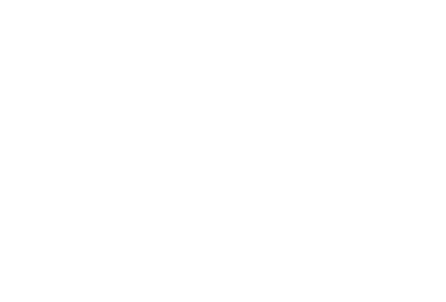

In [93]:
nx.draw(G)